# COVID-19 Data Analysis and Forecasting

#### Author: Joseph Denney
#### Email: joseph.d.denney@gmail.com
#### github: www.github.com/josephdenney/Covid_Analysis

## Introduction

### Problem and Purpose

#### This project will use forecasting to model Covid-19 deaths  based on current hospitalization, ventilator, and death data. I will be using API html links to bring in up to date data regularly. This project will use supervised learning in the form of ARIMA and SARIMAX in order to create time series death forecasts.

#### The purpose of this analysis is to provide an accurate forecast of Covid-19 related deaths as 2021 progresses.
#### Our challenges are -
#### * 1. Create multiple forecasts by creating forecasts for specific states
#### * 2. Build a forecast for the United States as a whole
#### * 3. Provide insights as to the urgency of making changes to how we are operating as a country

## Table of Contents

### Standard Libraries

In [1]:
from tensorflow.random import set_seed
import numpy as np

set_seed(42)
np.random.seed(42)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
%matplotlib inline
import functools
from jupyter_plotly_dash import JupyterDash
import datetime as dt
from datetime import date
from datetime import datetime, timedelta
import pandas_datareader as pdr
import holidays
# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output,State
# app = JupyterDash('our app')
# # pio.templates
# import plotly.express as px
# import plotly.io as pio

In [3]:
# import statsmodels.api as sm
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, TensorBoard

In [4]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [5]:
scaler = MinMaxScaler()
standard_scaler = StandardScaler()

In [6]:
import warnings
warnings.filterwarnings('ignore')

### Custom Libraries

In [7]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from Cust_Func import *

## Explore Data

### Create New DataFrame

In [8]:
open_links = False

In [9]:
import webbrowser

if open_links == True:
    webbrowser.open("https://covidtracking.com/")
    webbrowser.open("https://covidtracking.com/data/api")

#### The Covid Tracking Project was organized by the news agency The Atlantic early in 2020 in an effort to provide as much data on the pandemic as possible. Coordination of state by state Covid data required building working relationships with state officials to obtain relevant state information. Above are links to the project that can provide further information regarding Covid-19. Additionally, it is worth noting that the project is coming to its end at the beginning of March 2021 as a result of improvements to Federal collection of data. 

In [10]:
# set to true to fetch new data
get_data = True

In [11]:
if get_data == True:
    df_states = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv',index_col='date',parse_dates=True)
    df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)
    df_states.to_csv('StateData.csv')
    df_whole_US.to_csv('USA.csv')
else:
    df_states = pd.read_csv('StateData.csv', index_col='date', parse_dates=True)
    df_whole_US = pd.read_csv('USA.csv', index_col='date', parse_dates=True)

In [12]:
df_states.head()

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2021-02-10,AK,53991.0,NaN,NaN,NaN,totalTestsViral,1568003.0,34.0,1224.0,NaN,...,53991,0,1,baf68d880d4bd467802c16dcd7b66d8a228e6137,0,0,0,0,0,NaN
2021-02-10,AL,476067.0,102466.0,1830673.0,NaN,totalTestsPeopleViral,2204274.0,1401.0,43685.0,NaN,...,2306740,309,186,0daf535b515ad0db70e0dd283dbc5b236218df21,0,0,0,0,0,NaN
2021-02-10,AR,309940.0,64075.0,2306389.0,NaN,totalTestsViral,2552254.0,735.0,14211.0,283.0,...,2616329,26,37,7bc38ff5f537b736cba8b490100e49387dc29045,0,0,0,0,0,NaN
2021-02-10,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,NaN,...,2140,0,0,f2b562c1317d5a2b5e6b546f5e8d12a1937bcf8f,0,0,0,0,0,NaN
2021-02-10,AZ,789245.0,52525.0,2841495.0,NaN,totalTestsViral,7061776.0,2589.0,55088.0,763.0,...,3630740,176,121,94f1c11ee26d099f1b29e910fc17ec21627f0331,0,0,0,0,0,NaN


In [13]:
df_states.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19373 entries, 2021-02-10 to 2020-01-13
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   state                        19373 non-null  object 
 1   positive                     19184 non-null  float64
 2   probableCases                8318 non-null   float64
 3   negative                     15424 non-null  float64
 4   pending                      2014 non-null   float64
 5   totalTestResultsSource       19373 non-null  object 
 6   totalTestResults             19271 non-null  float64
 7   hospitalizedCurrently        16013 non-null  float64
 8   hospitalizedCumulative       11941 non-null  float64
 9   inIcuCurrently               10484 non-null  float64
 10  inIcuCumulative              3492 non-null   float64
 11  onVentilatorCurrently        8322 non-null   float64
 12  onVentilatorCumulative       1193 non-null   float64
 13 

In [14]:
df_whole_US.head()

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
date,,,,,,,,,,,,,,,,,,,,,
2021-02-10,56,27063243.0,125730666.0,12079.0,76979.0,834314.0,15788.0,43184.0,5121.0,4106.0,...,2021-02-10T24:00:00Z,NaN,0,0,3445,3226,406559,95194,1393156,9617441c49c13397399e16c97af8d2802228c1db
2021-02-09,56,26968049.0,125324107.0,10516.0,79179.0,831088.0,16129.0,43000.0,5216.0,4092.0,...,2021-02-09T24:00:00Z,NaN,0,0,2795,3144,544215,92986,1502502,1171d1f4d19e38fe981fe4ea36702d977051a9ba
2021-02-08,56,26875063.0,124779892.0,12114.0,80055.0,827944.0,16174.0,42833.0,5260.0,4080.0,...,2021-02-08T24:00:00Z,NaN,0,0,1309,1638,4866739,77737,1434298,fe5eb3c282fee2b8fa0cacce8bc9497711b286db
2021-02-07,56,26797326.0,119913153.0,12061.0,81439.0,826306.0,16616.0,42779.0,5342.0,4079.0,...,2021-02-07T24:00:00Z,NaN,0,0,1475,1543,393480,95994,1498467,652854f6dbc5adcea89dd9eb3338eba0c155b458
2021-02-06,56,26701332.0,119519673.0,12070.0,84233.0,824763.0,17093.0,42730.0,5475.0,4078.0,...,2021-02-06T24:00:00Z,NaN,0,0,2994,2443,518729,114557,1881694,049e3795a89dd7b777094aaecc923ed916ea3aee


### Plot of Ventilators and Deaths for Each State

In [15]:
df_states.columns.unique

<bound method Index.unique of Index(['state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'dateModified', 'checkTimeEt',
       'death', 'hospitalized', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestRe

In [16]:
df_states.isnull().sum()

state                              0
positive                         189
probableCases                  11055
negative                        3949
pending                        17359
totalTestResultsSource             0
totalTestResults                 102
hospitalizedCurrently           3360
hospitalizedCumulative          7432
inIcuCurrently                  8889
inIcuCumulative                15881
onVentilatorCurrently          11051
onVentilatorCumulative         18180
recovered                       5469
dataQualityGrade                1335
lastUpdateEt                     584
dateModified                     584
checkTimeEt                      584
death                            871
hospitalized                    7432
dateChecked                      584
totalTestsViral                 6546
positiveTestsViral             11923
negativeTestsViral             14909
positiveCasesViral              5786
deathConfirmed                 10356
deathProbable                  12475
t

In [17]:
# columns to keep in dataframe
columns = ['state','death','inIcuCurrently','onVentilatorCurrently','positive','hospitalizedCurrently','deathIncrease']

In [18]:
for col in columns:
    df_states[col] = df_states[col].fillna(0)

In [19]:
df_states = sort_and_clean_df(dataframe=df_states, target_columns=columns, percent_data_threshold=.05)

In [20]:
df_states.iloc[:50].sort_values(by='death',ascending=False) # only graph the top 7 
# that keep state ventilator data

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
date,,,,,,,
2021-02-10,CA,44995.0,3127.0,0.0,3362981.0,11516.0,518
2021-02-10,TX,39386.0,2740.0,0.0,2517453.0,9165.0,385
2021-02-10,NY,36619.0,1423.0,955.0,1494187.0,7593.0,138
2021-02-10,FL,28691.0,0.0,0.0,1765659.0,5129.0,165
2021-02-10,PA,22745.0,569.0,293.0,880291.0,2789.0,125
2021-02-10,NJ,22250.0,533.0,341.0,732674.0,2786.0,147
2021-02-10,IL,21869.0,464.0,232.0,1152995.0,2082.0,67
2021-02-10,MI,15939.0,299.0,149.0,624970.0,1175.0,14
2021-02-10,GA,15421.0,0.0,0.0,950906.0,3617.0,120


In [21]:
df_states['state'].unique() # list of states to iterate through

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [22]:
# list of unique state postal codes
# state_postal = ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
#        'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
#        'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
#        'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
#        'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
#        'WY']

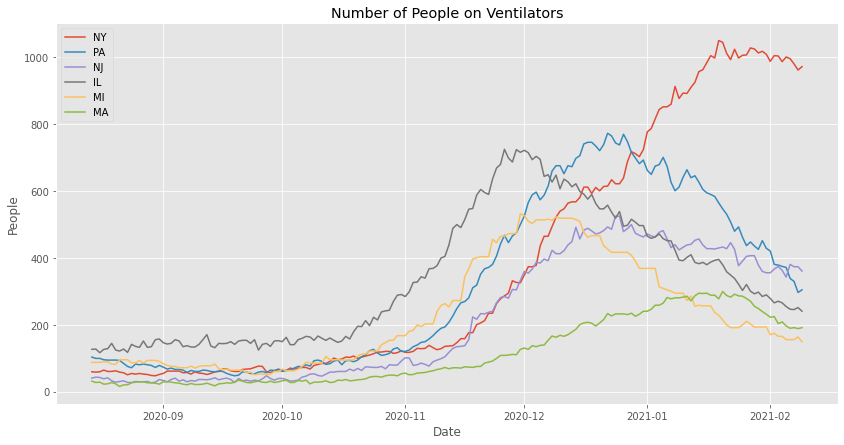

In [23]:
# for loop iterates through shortened list and prints ventilator usage
# for the trailing 180 day period. 
state_postal = ['NY', 'PA', 'NJ','IL','MI','MA']

fig = plt.figure(figsize=(14,7));

for state in state_postal:
    df_individual = df_states[df_states['state']==state]['onVentilatorCurrently'].sort_index()
    df_plot = df_individual.iloc[(df_individual.index.argmax()-180):(df_individual.index.argmax())]
    plt.plot(df_plot,label=f'{state}');
    plt.title('Number of People on Ventilators')
    plt.xlabel('Date')
    plt.ylabel('People')
    plt.legend();

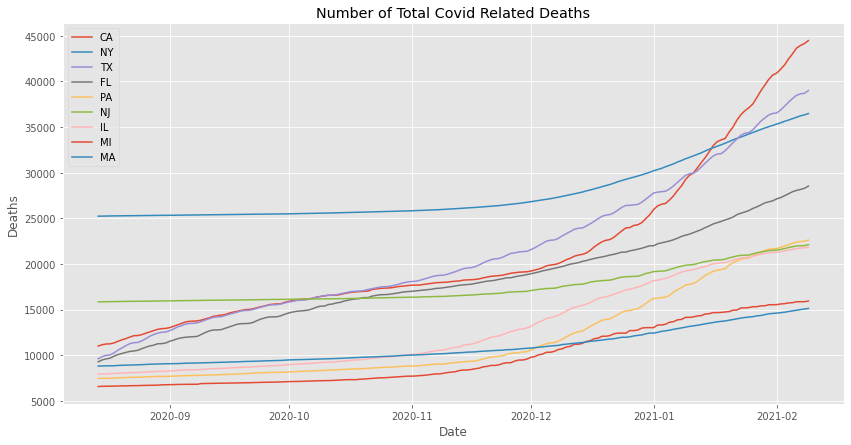

In [24]:
# same as above graph - all states have death data, this is a graph of the
# states with the highest covid mortality 
state_postal = ['CA', 'NY', 'TX', 'FL', 'PA', 'NJ','IL','MI','MA'] # highest death count states
# some do not have ventilator data reported. 

fig = plt.figure(figsize=(14,7));

for state in state_postal:
    df_individual = df_states[df_states['state']==state].death.sort_index()
    df_plot = df_individual.iloc[(df_individual.index.argmax()-180):(df_individual.index.argmax())]
    plt.plot(df_plot,label=f'{state}');
    plt.title('Number of Total Covid Related Deaths')
    plt.xlabel('Date')
    plt.ylabel('Deaths')
    plt.legend();

### Plot Alaska Death Count

In [25]:
df_AK = df_states[df_states['state']=='AK'] # just look at Alaska for now

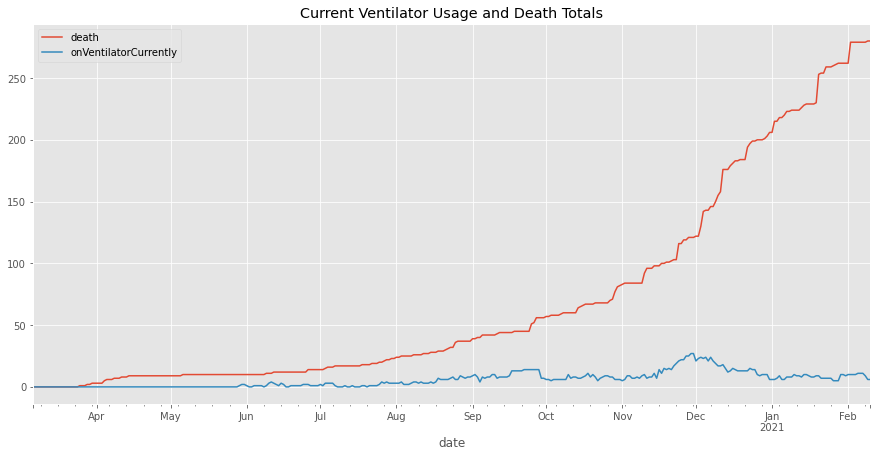

In [26]:
fig = plt.figure(figsize=(15,7));

df_AK['death'].plot(legend=True,title='Current Ventilator Usage and Death Totals');
df_AK['onVentilatorCurrently'].plot(legend=True);

# Modeling and Forecasts

## SARIMAX Modeling

### New York State Ventilator Usage Forecast

#### NY State was one of the first states to experience the worst of the pandemic. In addition to this, they are one of the most populous states in the country, and have had a spike in Covid cases post-holidays.

In [27]:
df = state_dataframe(df_states, 'NY')

Successfully returned indexed dataframe for NY


In [28]:
df_ref = state_dataframe(df_states, 'NY')

Successfully returned indexed dataframe for NY


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 346 entries, 2020-03-02 to 2021-02-10
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  346 non-null    object 
 1   death                  346 non-null    float64
 2   inIcuCurrently         346 non-null    float64
 3   onVentilatorCurrently  346 non-null    float64
 4   positive               346 non-null    float64
 5   hospitalizedCurrently  346 non-null    float64
 6   deathIncrease          346 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 21.6+ KB


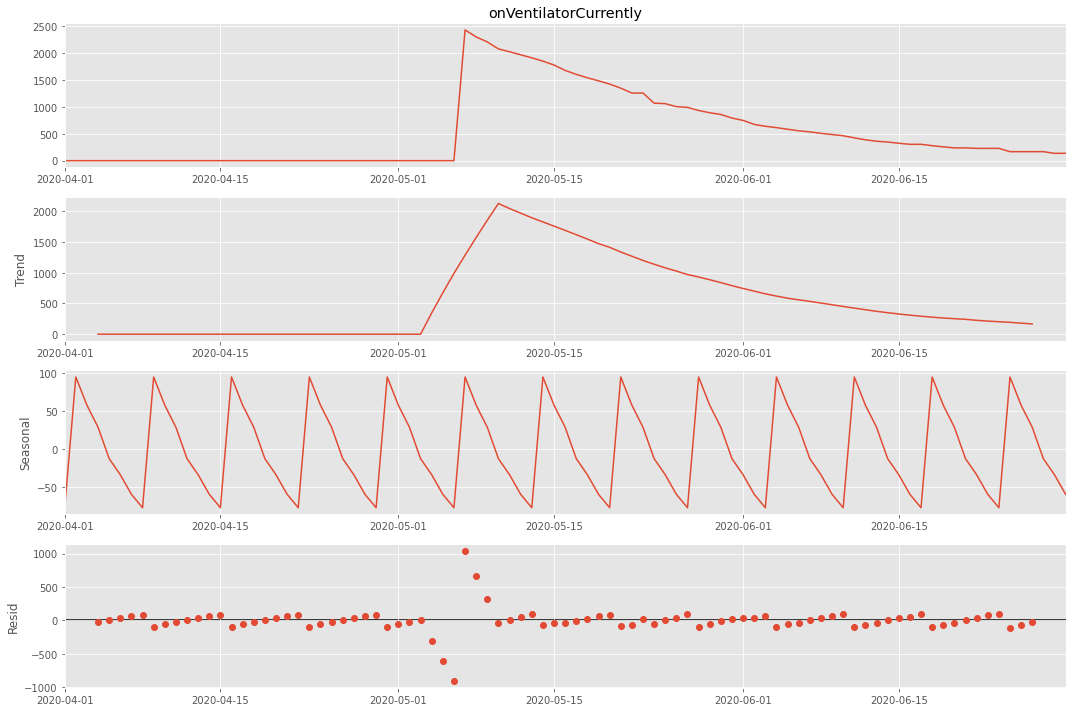

In [30]:
plt.rcParams['figure.figsize']=(15,10);
sd(df.loc['04-2020':'06-2020']['onVentilatorCurrently']).plot();

ARIMA order is:  (4, 2, 4)
Seasonal ARIMA order is:  (1, 0, 1, 6)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               onVentilatorCurrently   No. Observations:                  240
Model:             SARIMAX(4, 2, 4)x(1, 0, [1], 6)   Log Likelihood                -862.765
Date:                             Wed, 10 Feb 2021   AIC                           1747.529
Time:                                     17:45:08   BIC                           1785.204
Sample:                                 05-17-2020   HQIC                          1762.731
                                      - 01-11-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9412      0.072    -27.018      0.000      -2.082      -1.800
ar.L2         -2.0117      0.101    -20.016      0.000      -2.209      -1.815
ar.L3         -1.3848      0.092    -15.046      0.000      -1.565      -1.204
ar.L4         -0.4881      0.050     -9.857      0.000      -0.585      -0.391
ma.L1          1.0841      0.077     14.070      0.000       0.933       1.235
ma.L2          0.2846      0.082      3.471      0.001       0.124       0.445
ma.L3         -0.4837      0.084     -5.790      0.000      -0.647      -0.320
ma.L4         -0.4968      0.087     -5.726      0.000      -0.667      -0.327
ar.S.L6       -0.0180      0.025     -0.710      0.478      -0.068       0.032
ma.S.L6        0.1417      0.072      1.959      0.050   -7.07e-05       0.283
sigma2       116.8609      7.080     16.505      0.000     102.984     130.738
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               193.95
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.39
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

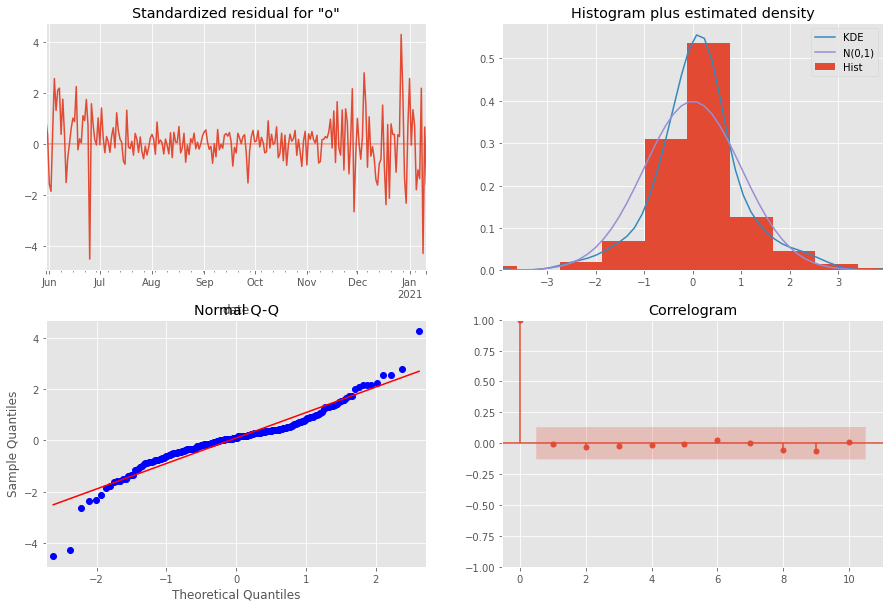

In [31]:
stepwise_fit, stepwise_full, results, results_full = arima_tune(df, 'onVentilatorCurrently', days_to_forecast=30, m_periods=6, verbose=True) 
# train days arg defaults to 270 days, but can be changed. seasonality can be adjusted as well
# see docstring for further details

#### The ends of the q-q plot are not quite in line.

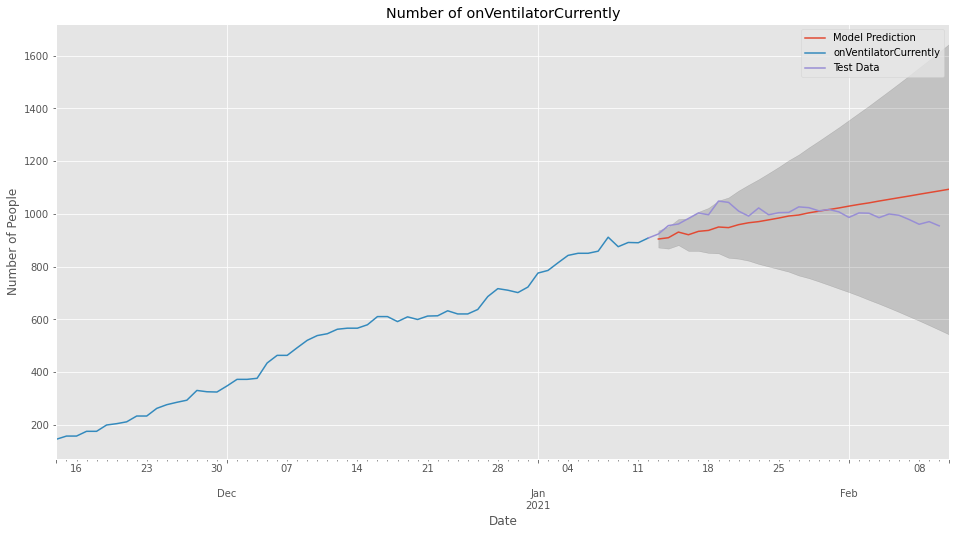

In [32]:
evaluate_predictions(results, df, 'onVentilatorCurrently', stepwise_fit=stepwise_fit, alpha=.05, days_to_forecast=30)
# plot training time and test time

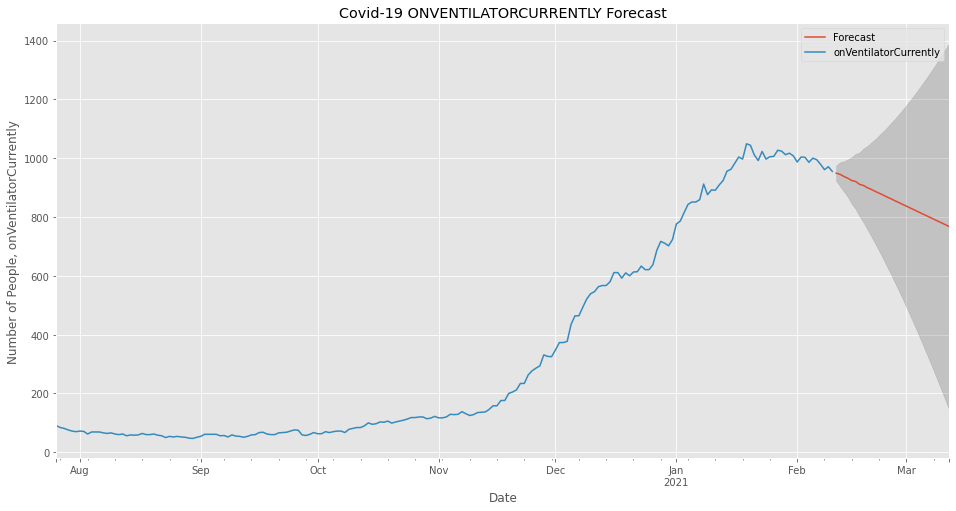

In [33]:
exog_forecast, forecast_obj = build_SARIMAX_forecast(model=results_full, 
                                                     dataframe=df, 
                                                     target_column='onVentilatorCurrently', 
                                                     days_to_forecast=30, stepwise_fit=stepwise_full, 
                                                     alpha=.05)

### New York State Deaths Forecast 
#### Modeled using New York's Ventilator Usage Forecast

In [34]:
stepwise_fit, df_forecast = get_exogenous_forecast_dataframe(dataframe=df,
                                                             original_dataframe=df_ref,
                                                             exog_forecast=exog_forecast, 
                                                             target_column='death',
                                                             exogenous_column='onVentilatorCurrently',
                                                             days_to_forecast=30,
                                                             m_periods=6)

In [36]:
df_forecast.tail(5)

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
2021-03-07,NaN,NaN,NaN,799.048227,NaN,NaN,NaN
2021-03-08,NaN,NaN,NaN,792.821167,NaN,NaN,NaN
2021-03-09,NaN,NaN,NaN,786.451726,NaN,NaN,NaN
2021-03-10,NaN,NaN,NaN,780.196028,NaN,NaN,NaN
2021-03-11,NaN,NaN,NaN,773.858953,NaN,NaN,NaN


In [37]:
full_exog_model = SARIMAX(df['death'],df['onVentilatorCurrently'],
                          order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order)

In [38]:
# fit model 
model = full_exog_model.fit()

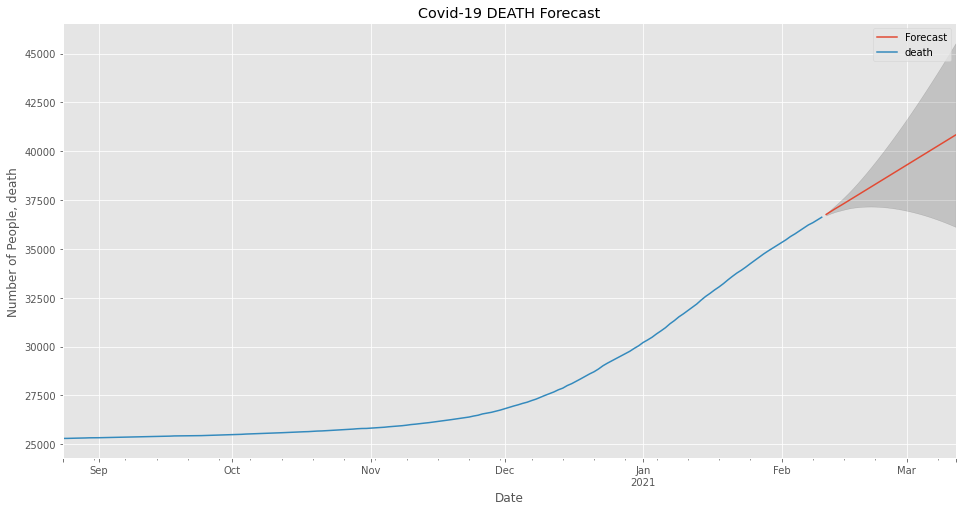

In [39]:
exog_forecast, results_forecast = build_SARIMAX_forecast(model=model,
                                                         dataframe=df_forecast, 
                                                         target_column='death', 
                                                         days_to_forecast=30, 
                                                         stepwise_fit=stepwise_fit, 
                                                         alpha=.05,
                                                         original_df=df_ref,
                                                         exogenous_column='onVentilatorCurrently')

### Texas Hospitalized Forecast

#### Texas is also a populous state and also has been inclined to open back up quickly to keep the economy going. Additionally, they have not reported ICU or Ventilator numbers to the Covid Tracking Project. 

In [40]:
df = state_dataframe(df_states, 'TX')

Successfully returned indexed dataframe for TX


In [41]:
df_ref = state_dataframe(df_states, 'TX')

Successfully returned indexed dataframe for TX


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345 entries, 2020-03-03 to 2021-02-10
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  345 non-null    object 
 1   death                  345 non-null    float64
 2   inIcuCurrently         345 non-null    float64
 3   onVentilatorCurrently  345 non-null    float64
 4   positive               345 non-null    float64
 5   hospitalizedCurrently  345 non-null    float64
 6   deathIncrease          345 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 21.6+ KB


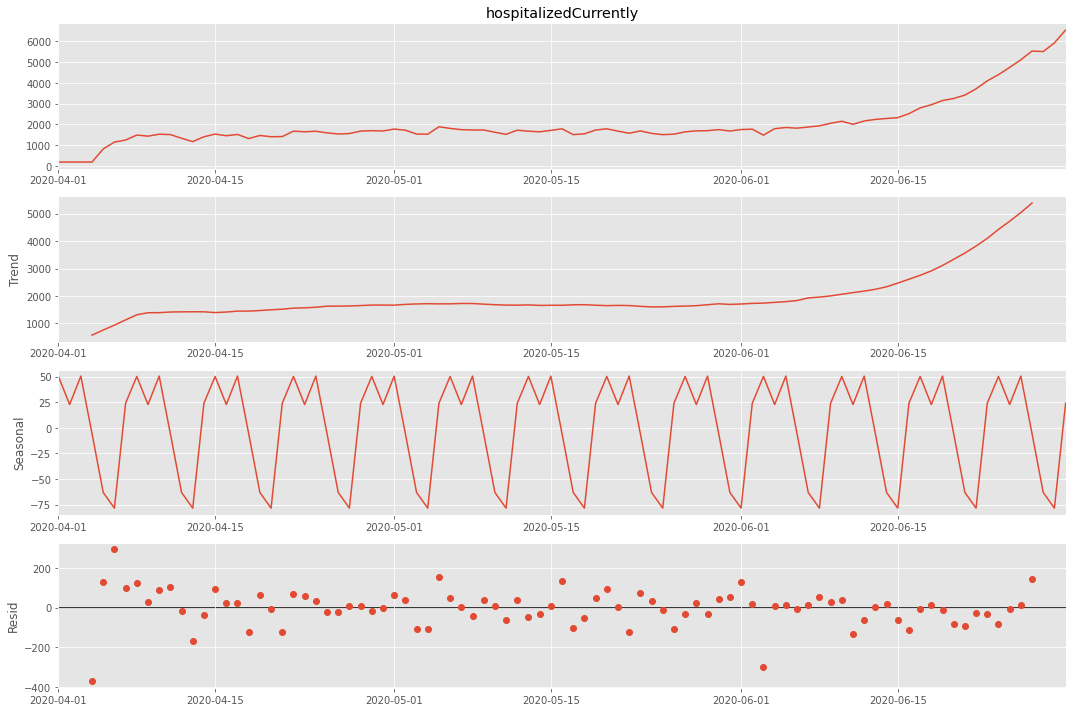

In [43]:
plt.rcParams['figure.figsize']=(15,10);
sd(df.loc['04-2020':'06-2020']['hospitalizedCurrently']).plot();

ARIMA order is:  (1, 1, 1)
Seasonal ARIMA order is:  (0, 0, 0, 6)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     hospitalizedCurrently   No. Observations:                  240
Model:                  SARIMAX(1, 1, 1)   Log Likelihood               -1554.716
Date:                   Wed, 10 Feb 2021   AIC                           3115.432
Time:                           17:46:42   BIC                           3125.837
Sample:                       05-17-2020   HQIC                          3119.626
                            - 01-11-2021                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9666      0.021     46.171      0.000       0.926       1.008
ma.L1         -0.7809      0.049    -15.819      0.000      -0.878      -0.684
sigma2      2.914e+04    967.927     30.106      0.000    2.72e+04     3.1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):              3678.22
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -2.56
Prob(H) (two-sided):                  0.23   Kurtosis:                        21.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

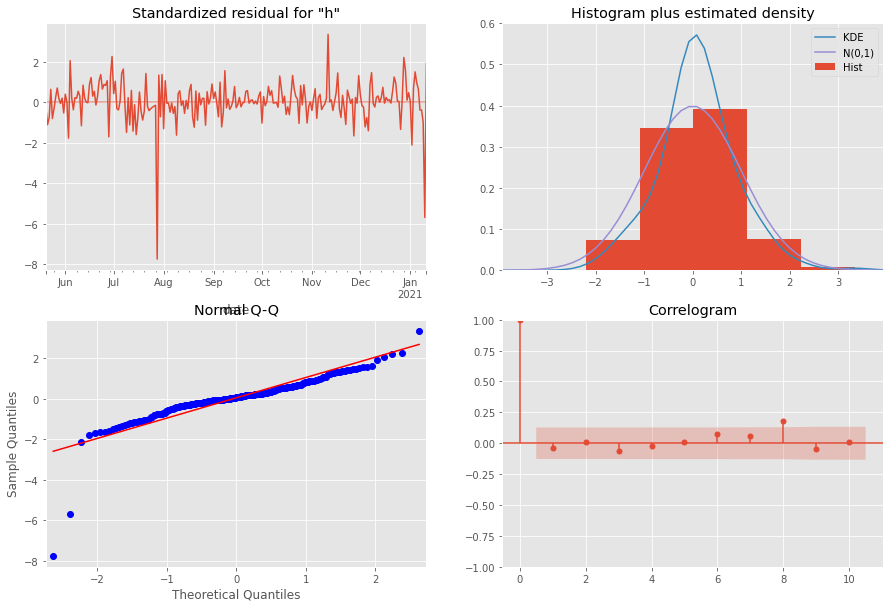

In [44]:
stepwise_fit, stepwise_full, results, results_full = arima_tune(df, 'hospitalizedCurrently', days_to_forecast=30, m_periods=6, verbose=True) 
# train days arg defaults to 270 days, but can be changed. seasonality can be adjusted as well
# see docstring for further details

#### The ends of the q-q plot are not quite in line.

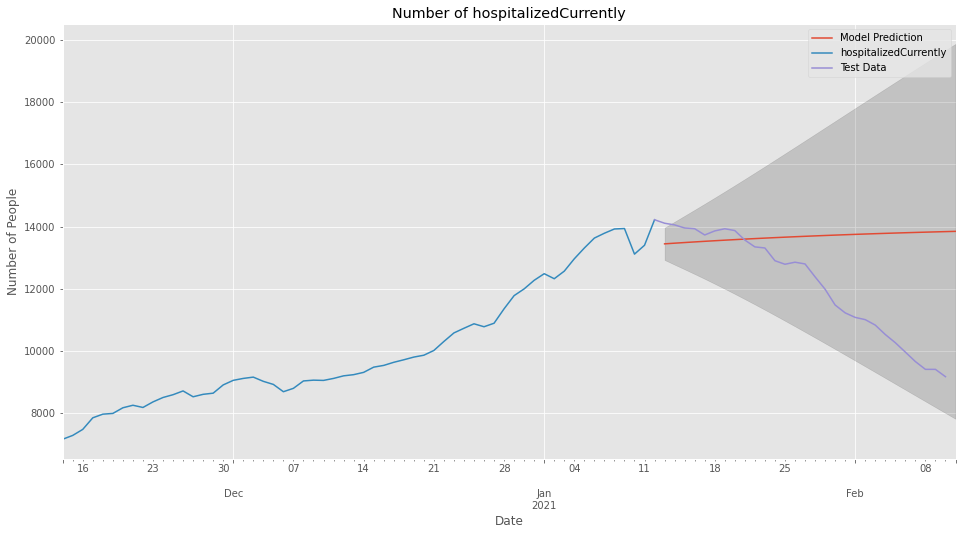

In [45]:
evaluate_predictions(results, df, 'hospitalizedCurrently', stepwise_fit=stepwise_fit, alpha=.05, days_to_forecast=30)
# plot training time and test time

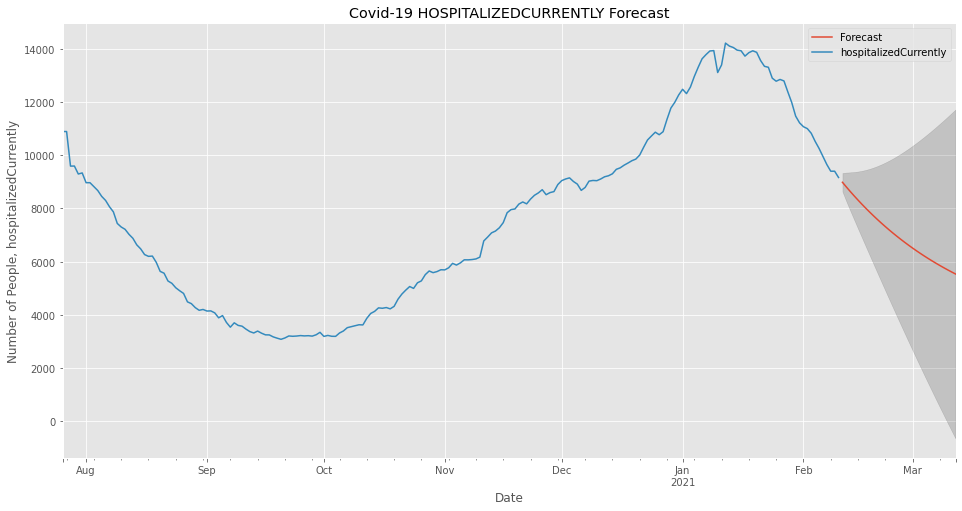

In [46]:
exog_forecast, forecast_obj = build_SARIMAX_forecast(model=results_full, 
                                                     dataframe=df, 
                                                     target_column='hospitalizedCurrently', 
                                                     days_to_forecast=30, stepwise_fit=stepwise_full, 
                                                     alpha=.05)

### Texas Deaths Forecast
#### Modeled using Texas's Hospitalized Forecast

In [47]:
stepwise_fit, df_forecast = get_exogenous_forecast_dataframe(dataframe=df,
                                                             original_dataframe=df_ref,
                                                             exog_forecast=exog_forecast, 
                                                             target_column='death',
                                                             exogenous_column='hospitalizedCurrently',
                                                             days_to_forecast=30,
                                                             m_periods=6)

In [48]:
stepwise_fit.seasonal_order

(1, 0, 0, 6)

In [49]:
df_forecast.tail(5)

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
2021-03-07,NaN,NaN,NaN,NaN,NaN,5940.345581,NaN
2021-03-08,NaN,NaN,NaN,NaN,NaN,5854.908822,NaN
2021-03-09,NaN,NaN,NaN,NaN,NaN,5771.989334,NaN
2021-03-10,NaN,NaN,NaN,NaN,NaN,5691.512948,NaN
2021-03-11,NaN,NaN,NaN,NaN,NaN,5613.407683,NaN


In [50]:
full_exog_model = SARIMAX(df['death'],df['hospitalizedCurrently'],
                          order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order)

In [51]:
# fit model 
model = full_exog_model.fit()

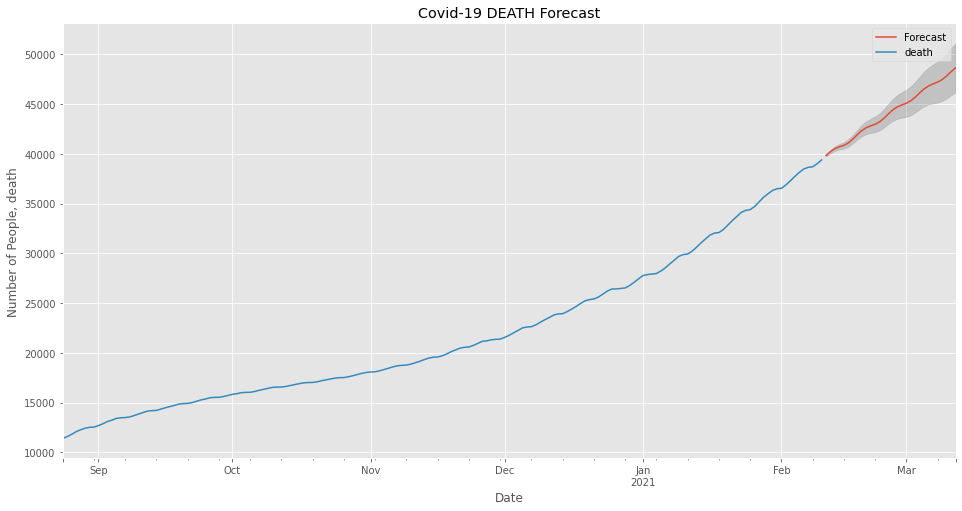

In [52]:
exog_forecast, results_forecast = build_SARIMAX_forecast(model=model,
                                                         dataframe=df_forecast, 
                                                         target_column='death', 
                                                         days_to_forecast=30, 
                                                         stepwise_fit=stepwise_fit, 
                                                         alpha=.05,
                                                         original_df=df_ref,
                                                         exogenous_column='hospitalizedCurrently')

In [71]:
results_forecast.predicted_mean[-5:]

2021-03-08    47211.754332
2021-03-09    47463.698107
2021-03-10    47824.514779
2021-03-11    48248.596027
2021-03-12    48644.373588
Freq: D, Name: predicted_mean, dtype: float64

### California Deaths Forecast
#### Modeled using ICU Forecast

In [53]:
df_ref = state_dataframe(df_states, 'CA')

Successfully returned indexed dataframe for CA


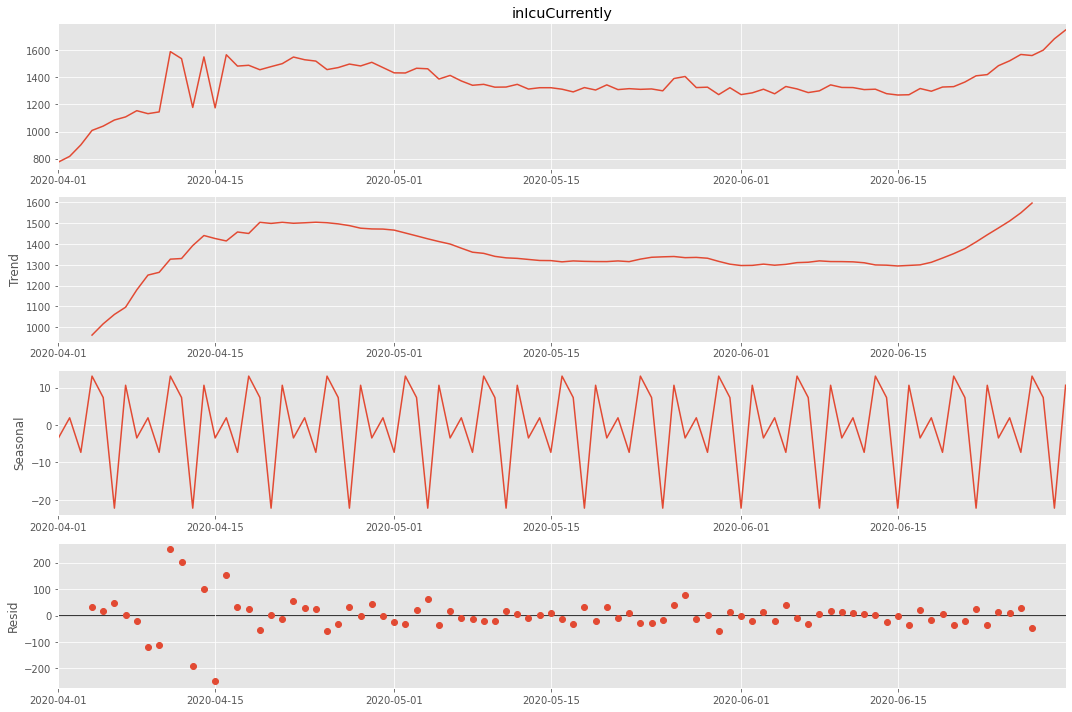

In [66]:
plt.rcParams['figure.figsize']=(15,10);
sd(df_ref.loc['04-2020':'06-2020']['inIcuCurrently']).plot();

Successfully returned indexed dataframe for CA
ARIMA order is:  (1, 2, 2)
Seasonal ARIMA order is:  (0, 0, 0, 7)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         inIcuCurrently   No. Observations:                  240
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -1172.650
Date:                Wed, 10 Feb 2021   AIC                           2353.300
Time:                        18:01:20   BIC                           2367.139
Sample:                    05-17-2020   HQIC                          2358.879
                         - 01-11-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8865      0.077    -11.538      0.000      -1.037      -0.736
ma.L1         -0.0553      0.108     -0.510      0.610      -0.268       0.157
ma.L2         -0.6589      0.098     -6.743      0.000      -0.850      -0.467
sigma2      1261.4033     98.874     12.758      0.000    1067.613    1455.193
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                23.19
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.59
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

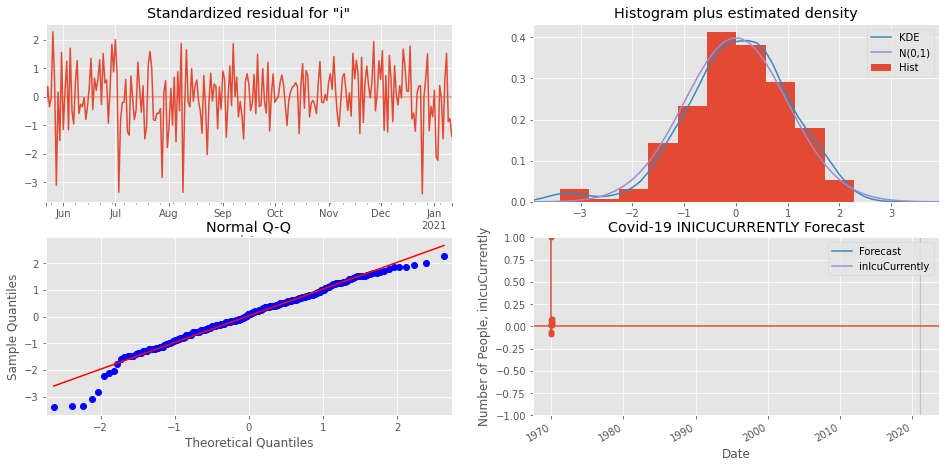

In [67]:
state_dataframe, exog_forecast = create_exog_forecast(df_states, 'inIcuCurrently', m_periods=7, state_postal_code='CA')

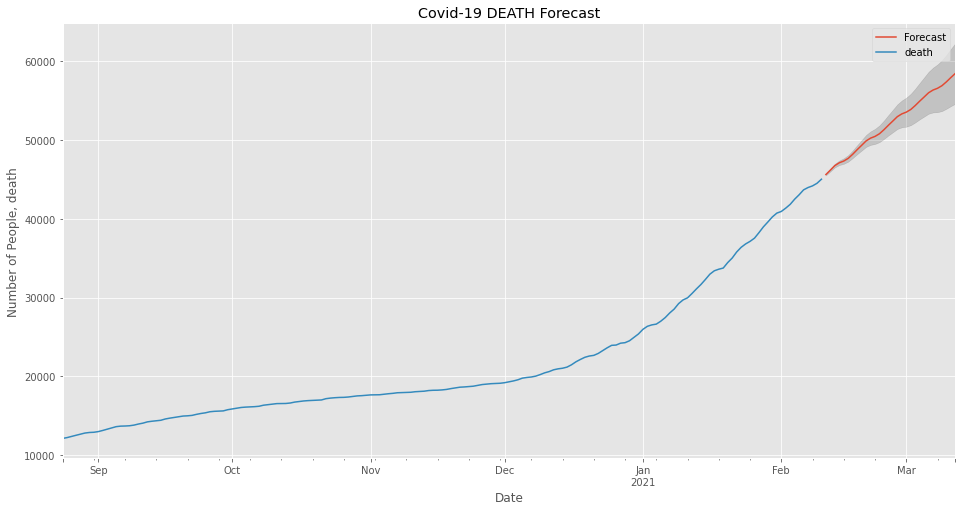

In [68]:
forecast_object = graph_exog_forecast(dataframe=state_dataframe, 
                                      target_column='death', 
                                      exogenous_column='inIcuCurrently', 
                                      exog_forecast=exog_forecast,
                                      df_ref=df_ref, 
                                      alpha=.05, days_to_forecast=30, 
                                      train_days=270, m_periods=7)

In [69]:
forecast_object.predicted_mean[-5:] # projected mean deaths for California
# by the end of March 

2021-03-08    56514.531202
2021-03-09    56846.265604
2021-03-10    57336.151180
2021-03-11    57881.805774
2021-03-12    58401.997889
Freq: D, Name: predicted_mean, dtype: float64

In [70]:
# questions and analysis

In [ ]:
# README.md

In [72]:
# put together slides, non-technical presentation

In [73]:
# provide further notes in appendix style for univariate and multivariate NN forecasting

### Alaska SARIMA Model

In [72]:
df_AK = df_AK.sort_index()

In [73]:
df_AK = df_AK.dropna(subset=['death'])
df_AK = df_AK.dropna(subset=['onVentilatorCurrently'])

In [74]:
df_alaska = pd.DataFrame(df_AK)

In [75]:
print(df_alaska.index.min())
print(df_alaska.index.max())
print('Length of dataframe: ' , len(df_alaska))

2020-03-06 00:00:00
2021-02-10 00:00:00
Length of dataframe:  342


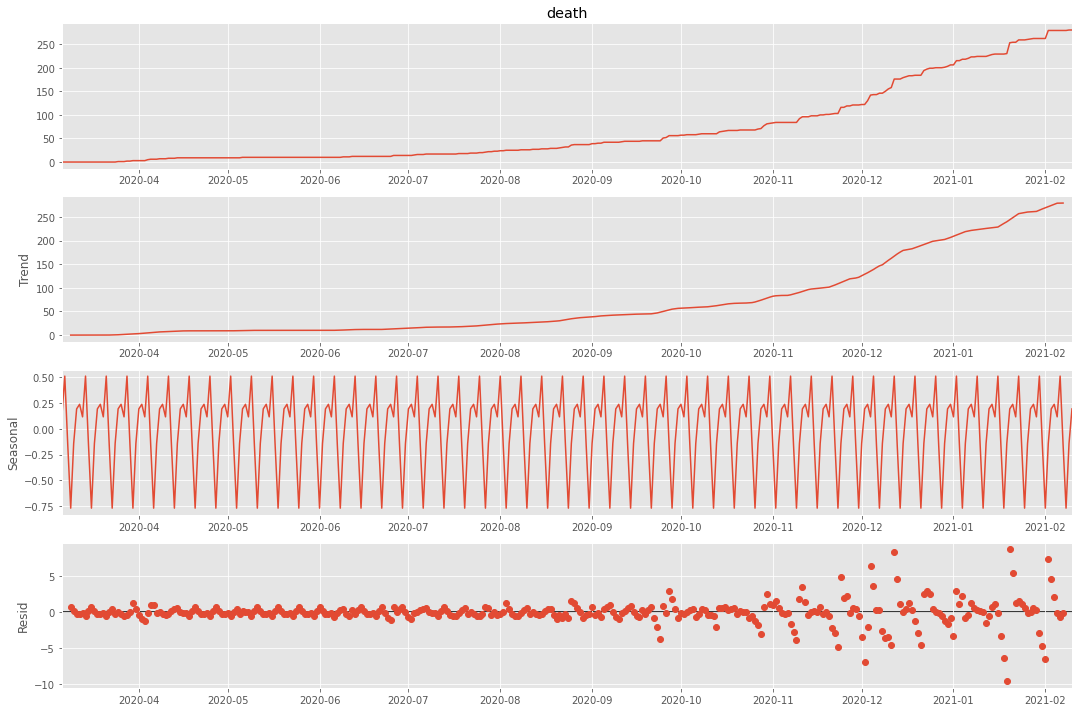

In [76]:
sd(df_alaska['death'], model='additive').plot(); # alaska = seasonal

In [77]:
stepwise_fit = auto_arima(df_alaska['death'],start_p=0,start_q=0,max_p=10,
                          max_q=10, seasonal=True, seasonal_test='ocsb', maxiter=75, method='lbfgs',
                          n_jobs=-1,stepwise=True)

In [78]:
model = SARIMAX(df_alaska['death'], order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  death   No. Observations:                  342
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -767.776
Date:                Wed, 10 Feb 2021   AIC                           1539.553
Time:                        18:04:05   BIC                           1547.211
Sample:                    03-06-2020   HQIC                          1542.604
                         - 02-10-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9663      0.010    -94.016      0.000      -0.986      -0.946
sigma2         5.3147      0.096     55.223      0.000       5.126       5.503
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             19498.25
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):             102.34   Skew:                             5.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
# dont forget get_predict
predictions_AK = model.get_forecast(30)

In [80]:
predictions_AK.predicted_mean

2021-02-11    281.766482
2021-02-12    283.532965
2021-02-13    285.299447
2021-02-14    287.065929
2021-02-15    288.832411
2021-02-16    290.598894
2021-02-17    292.365376
2021-02-18    294.131858
2021-02-19    295.898341
2021-02-20    297.664823
2021-02-21    299.431305
2021-02-22    301.197788
2021-02-23    302.964270
2021-02-24    304.730752
2021-02-25    306.497234
2021-02-26    308.263717
2021-02-27    310.030199
2021-02-28    311.796681
2021-03-01    313.563164
2021-03-02    315.329646
2021-03-03    317.096128
2021-03-04    318.862611
2021-03-05    320.629093
2021-03-06    322.395575
2021-03-07    324.162057
2021-03-08    325.928540
2021-03-09    327.695022
2021-03-10    329.461504
2021-03-11    331.227987
2021-03-12    332.994469
Freq: D, Name: predicted_mean, dtype: float64

In [81]:
predictions_AK.predicted_mean
predictions_AK.conf_int(alpha=.05) # lower and upper confidence intervals, 
# phase4 appendix will tell you how to graph and shade in between these two plots

# # Get forecast 500 steps ahead in future
# prediction = output.get_forecast(steps=500)

# # Get confidence intervals of forecasts
# pred_conf = prediction.conf_int()

# ax = CO2.plot(label='observed', figsize=(20, 15))
# prediction.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='k', alpha=0.25)
# ax.set_xlabel('Date')
# ax.set_ylabel('CO2 Levels')

# plt.legend()
# plt.show()

,lower death,upper death
2021-02-11,277.248067,286.284897
2021-02-12,277.034321,290.031608
2021-02-13,277.206530,293.392364
2021-02-14,277.565859,296.565999
2021-02-15,278.036723,299.628100
2021-02-16,278.581057,302.616731
2021-02-17,279.176657,305.554095
2021-02-18,279.809321,308.454396
2021-02-19,280.469371,311.327310
2021-02-20,281.149895,314.179751


In [82]:
stepwise_fit.order

(0, 2, 1)

In [83]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  342
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -766.413
Date:                Wed, 10 Feb 2021   AIC                           1538.826
Time:                        18:04:07   BIC                           1550.313
Sample:                             0   HQIC                          1543.403
                                - 342                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0068      0.004      1.873      0.061      -0.000       0.014
ma.L1         -0.9869      0.011    -87.999      0.000      -1.009      -0.965
sigma2         5.2578      0.188     27.941      0.000       4.889       5.627
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             20390.16
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              76.32   Skew:                             5.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
length = len(df_alaska)-45

In [85]:
train_data = df_alaska.iloc[:length]
test_data = df_alaska.iloc[length:]

In [86]:
train_data

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
date,,,,,,,
2020-03-06,AK,0.0,0.0,0.0,0.0,0.0,0
2020-03-07,AK,0.0,0.0,0.0,0.0,0.0,0
2020-03-08,AK,0.0,0.0,0.0,0.0,0.0,0
2020-03-09,AK,0.0,0.0,0.0,0.0,0.0,0
2020-03-10,AK,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
2020-12-23,AK,197.0,0.0,15.0,43361.0,111.0,3
2020-12-24,AK,199.0,0.0,14.0,43629.0,105.0,2
2020-12-25,AK,199.0,0.0,14.0,43629.0,105.0,0


In [87]:
test_data

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
date,,,,,,,
2020-12-28,AK,200.0,0.0,10.0,44406.0,78.0,0
2020-12-29,AK,201.0,0.0,10.0,44581.0,83.0,1
2020-12-30,AK,203.0,0.0,10.0,44966.0,75.0,2
2020-12-31,AK,206.0,0.0,6.0,45461.0,79.0,3
2021-01-01,AK,206.0,0.0,6.0,45461.0,79.0,0
2021-01-02,AK,215.0,0.0,6.0,46262.0,77.0,9
2021-01-03,AK,215.0,0.0,7.0,46552.0,87.0,0
2021-01-04,AK,218.0,0.0,9.0,46812.0,97.0,3
2021-01-05,AK,218.0,0.0,6.0,47006.0,93.0,0


In [88]:
model = sm.tsa.statespace.SARIMAX(train_data['death'],trend='ct', order=(0,2,1))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  297
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -598.993
Date:                Wed, 10 Feb 2021   AIC                           1205.986
Time:                        18:04:09   BIC                           1220.734
Sample:                    03-06-2020   HQIC                          1211.891
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0304      0.094     -0.325      0.746      -0.214       0.153
drift          0.0002      0.000      0.523      0.601      -0.001       0.001
ma.L1         -0.8444      0.019    -43.791      0.0

In [89]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [90]:
predictions_AK = res.predict(start,end,typ='endogenous').rename('SARIMAX(0,2,1) Predictions')

In [91]:
train_data.index

DatetimeIndex(['2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15',
               ...
               '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27'],
              dtype='datetime64[ns]', name='date', length=297, freq=None)

In [92]:
test_data.index

DatetimeIndex(['2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
               '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10'],
              dtype='datetime64[ns]', name='date', freq=None)

In [93]:
predictions_AK = pd.DataFrame(predictions_AK)

In [94]:
predictions_AK.index.name = 'date'

#### Compare Test Data with Predictions

In [95]:
train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

In [96]:
pd.DataFrame(test_data['death']).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-28 to 2021-02-10
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   death   45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


In [97]:
predictions_AK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-28 to 2021-02-10
Freq: D
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SARIMAX(0,2,1) Predictions  45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


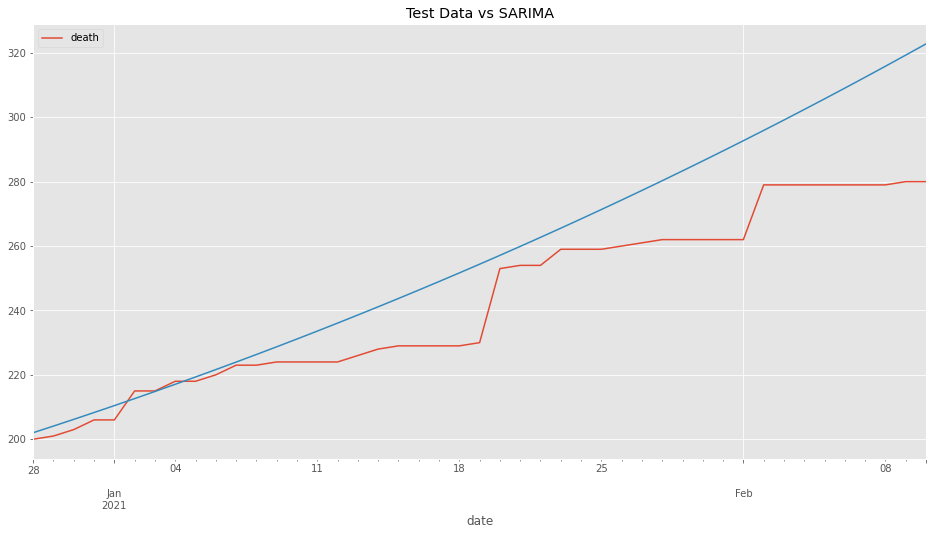

In [98]:
pd.DataFrame(test_data['death']).plot(figsize=(16,8),legend=True,title='Test Data vs SARIMA',grid=True)
plt.plot(pd.DataFrame(predictions_AK))
plt.show()

In [99]:
model = sm.tsa.statespace.SARIMAX(df_alaska['death'],trend='ct', order=(0,2,1))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  342
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -776.623
Date:                Wed, 10 Feb 2021   AIC                           1561.246
Time:                        18:04:13   BIC                           1576.561
Sample:                    03-06-2020   HQIC                          1567.348
                         - 02-10-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0350      0.100     -0.349      0.727      -0.231       0.161
drift          0.0002      0.000      0.430      0.667      -0.001       0.001
ma.L1         -0.8785      0.024    -36.079      0.0

In [100]:
fcast = res.predict(start=len(df_AK),end=len(df_AK)+45, typ='endogenous').rename('SARIMAX FORECAST')

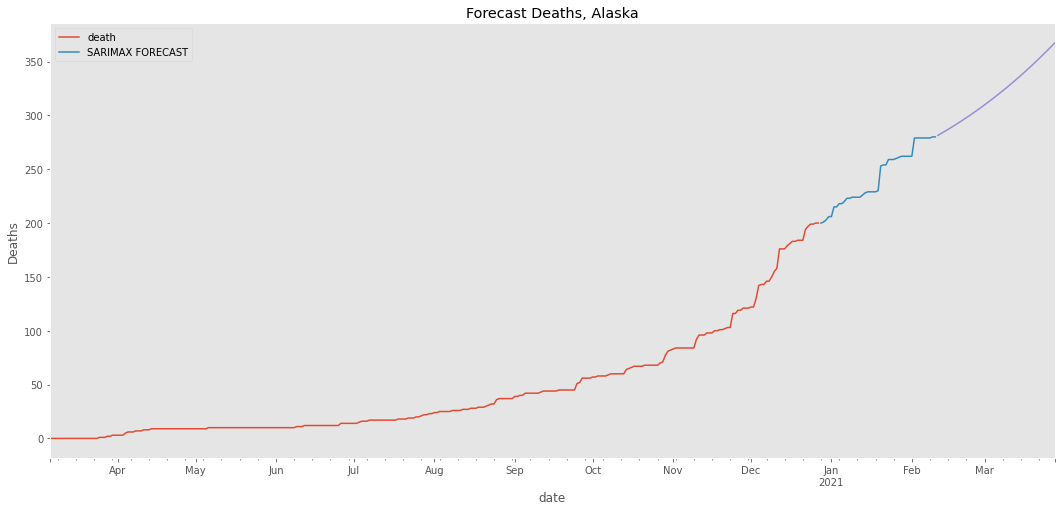

In [101]:
fig, ax = plt.subplots()

train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',title='Forecast Deaths, Alaska',grid=True);
test_data['death'].plot(grid=True);
fcast.plot(legend=True,figsize=(18,8)); 
ax.grid();
plt.show();

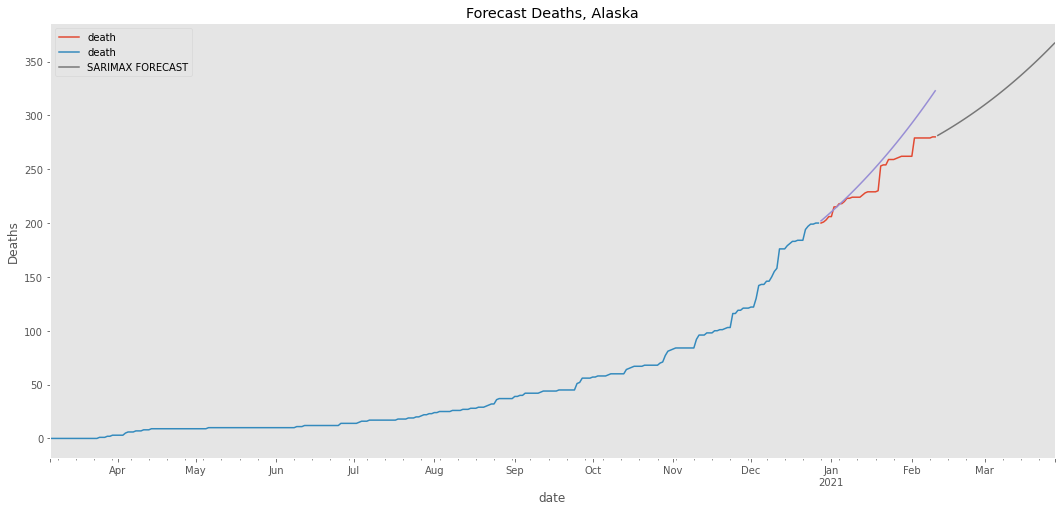

In [102]:
fig, ax = plt.subplots()

test_data['death'].plot(figsize=(16,8),legend=True,title='Forecast Deaths, Alaska',grid=True);
train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',grid=True);
plt.plot(pd.DataFrame(predictions_AK)); # 'FORECAST' FROM END OF TRAINING DATA
fcast.plot(legend=True,figsize=(18,8)); # SARIMA FORECAST
ax.grid();
plt.show();

## Univariate Forecast with RNN

### Texas

Epoch 1/4
295/295 [==============================] - 10s 28ms/step - loss: 0.0271
Epoch 2/4
295/295 [==============================] - 10s 32ms/step - loss: 3.4662e-04
Epoch 3/4
295/295 [==============================] - 10s 34ms/step - loss: 5.8270e-04
Epoch 4/4
295/295 [==============================] - 10s 34ms/step - loss: 2.4545e-04


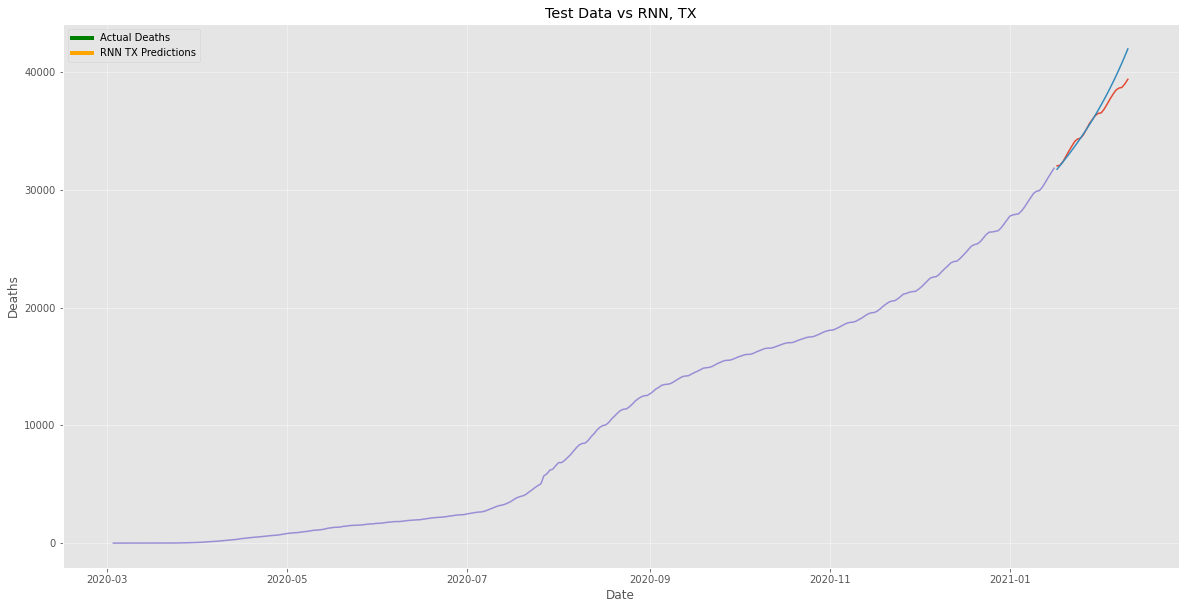

In [105]:
create_NN_predict(df_states=df_states,state_postal_code='TX',days=25,epochs=4) 

### Florida

Epoch 1/4
339/339 [==============================] - 12s 30ms/step - loss: 0.0303
Epoch 2/4
339/339 [==============================] - 9s 26ms/step - loss: 3.1630e-04
Epoch 3/4
339/339 [==============================] - 9s 27ms/step - loss: 7.7476e-04: 1s - loss: 8.3
Epoch 4/4
339/339 [==============================] - 9s 26ms/step - loss: 9.1512e-04: 0s - loss: 9.174


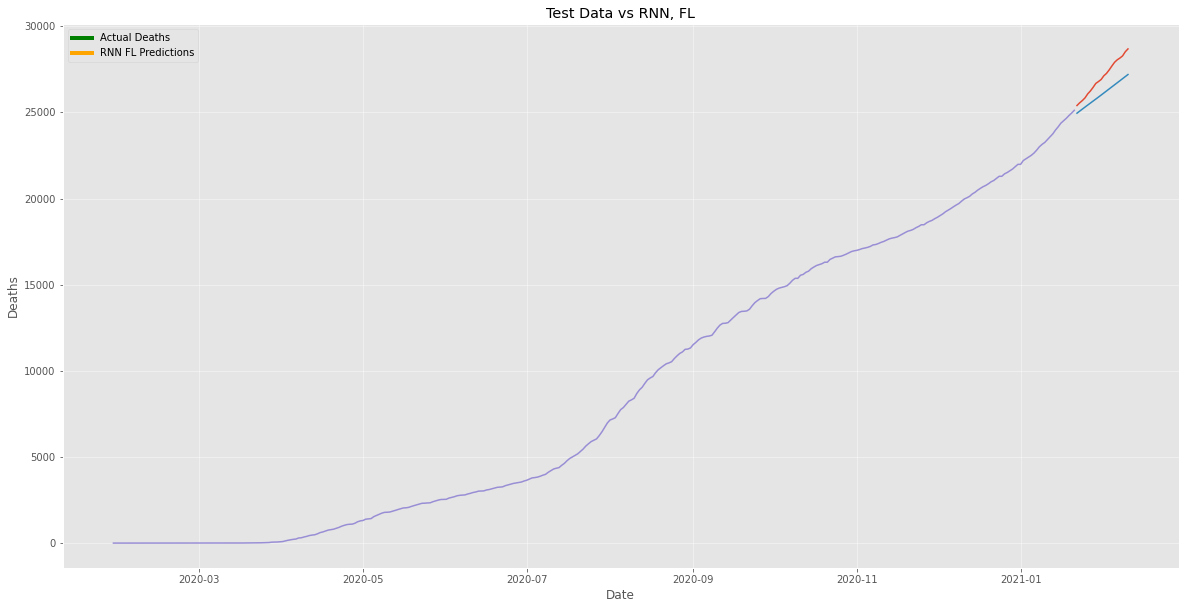

In [106]:
create_NN_predict(df_states,'FL',20,epochs=4)

### California

In [ ]:
create_NN_predict(df_states,'CA',20,epochs=4)

## Using an Exogenous Variable with SARIMAX

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

calendar = calendar()
holidays = calendar.holidays(start=df_states.index.min(), end=df_states.index.max())

df_states['holiday'] = df_states.index.isin(holidays)

df_whole_US['holiday'] = df_whole_US.index.isin(holidays)

In [ ]:
df_states = clean_df(df_states,.05)

In [ ]:
state_postal_code = 'TX'
days = 30

df_state = df_states[df_states['state']==state_postal_code]    

# sort index, lowest index to oldest date, drop na's in death column
df_state = df_state.sort_index()
df_state = df_state.dropna(subset=['death'])
df_state_new = pd.DataFrame(df_state)

#     ets_decomp = sd(df_state_new['death'])
#     ets_decomp.plot();

# create stepwise fit model, see summary
stepwise_fit = auto_arima(df_state_new['death'],seasonal=True,m=52,maxiter=2)

# auto_arima automatically differences and returns that differencing for the model in the arima_order = stepwise_fit.order below
## find correct ARIMA order

arima_order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order

length = len(df_state_new)-days

train_data = df_state_new.iloc[:length]
test_data = df_state_new.iloc[length:]

model = sm.tsa.statespace.SARIMAX(train_data['death'], trend='ct', seasonal_order=seasonal_order, 
                                  order=arima_order, enforce_invertibility=False)
res = model.fit()

start = len(train_data)
end = len(train_data) + len(test_data) - 1

predictions_state = res.predict(start,end,dynamic=False).rename(f'SARIMAX {arima_order} Predictions')

# ensure predictions are in DataFrame format, label index as date to match df_alaska
predictions_state = pd.DataFrame(predictions_state)
predictions_state.index.name = 'date'

train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

# graph test vs. prediction data - {PLOT}
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual Deaths'),
                   Line2D([0], [0], color='#FFA500', lw=4, label=f'SARIMAX {arima_order} Predictions')]

fig, ax = plt.subplots(figsize=(20,10));
ax.plot(test_data['death'])
ax.plot(predictions_state);
ax.grid(b=True,alpha=.5)
plt.title(f'Test Data vs SARIMA, {state_postal_code}')
ax.legend(handles=legend_elements)
for x in test_data.index:
    if test_data['holiday'].loc[x]==1:    # for days where holiday == 1
        ax.axvline(x=x, color='red', alpha = 0.4);   
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show();

error1 = mse(test_data['death'], predictions_state)
error2 = rmse(test_data['death'], predictions_state)

# print(f'SARIMAX{arima_order}{seasonal_order} MSE Error: {error1}')
# print(f'SARIMAX{arima_order}{seasonal_order} RMSE Error: {error2}')

# train model for forecast
model = sm.tsa.statespace.SARIMAX(df_state_new['death'],exog=df_state_new['holiday'],
                                  order=arima_order, seasonal_order=seasonal_order,
                                  enforce_invertibility=False)
res = model.fit(disp=False)

# create forecast
exog_forecast = df_state_new[length:][['holiday']]
fcast = res.predict(start=len(df_state_new),end=len(df_state_new)+days-1,exog=exog_forecast).rename(f'SARIMAX{arima_order},{seasonal_order} {days} Days Forecast')

# graph forecast deaths, breakout of train and test split is present in graph - {PLOT}
legend_elements = [Line2D([0], [0], color='b', lw=5, label='Actual Deaths'),
                   Line2D([0], [0], color='#FFA500', lw=5, label='Actual Deaths'),
                   Line2D([0], [0], color='g', lw=5, label=f'SARIMAX {arima_order} , {seasonal_order} Predictions'),
                   Line2D([0], [0], color='r', lw=5, label=f'SARIMAX {arima_order} , {seasonal_order} {days} Day Forecast')]

fig, ax = plt.subplots(figsize=(20,10));
ax.plot(train_data['death'])
ax.plot(test_data['death'])
ax.plot(predictions_state)
ax.plot(fcast)
ax.grid(b=True,alpha=.5)
plt.title(f'SARIMAX {days} Day Forecast, {state_postal_code}')
ax.legend(handles=legend_elements)
for x in df_state_new.index:
    if df_state_new['holiday'].loc[x]==1:    # for days where holiday == 1
        ax.axvline(x=x, color='red', alpha = 0.4);   
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show();

last_predictions = len(fcast)-5
actual_numbers = fcast[last_predictions:]

return actual_numbers

### Texas

In [ ]:
create_SAX(df_states,'TX',30)

#### An exogenous SARIMA model is taking holidays into account and provides an accurate picture. Red vertical lines represent holidays. Green and orange graphed lines in the second graph are the evaluation of the model against the Test Data. Forecasted data is putting Texas deaths at 44,000 by February 22nd. 

#### The largest states in the country are problem areas because of their concentrations of populations in large metropolitan areas, regardless of political leanings or affiliations. People need to be more careful and stay away from others on a more strict basis.

### California

In [ ]:
create_SAX(df_states,'CA',30)

#### An exogenous SARIMA model is taking holidays into account and provides an accurate picture. Red vertical lines represent holidays. Green and orange graphed lines in the second graph are the evaluation of the model against the Test Data. Forecasted data is putting California deaths at 51,000 by February 22nd. 

#### The largest states in the country are problem areas because of their concentrations of populations in large metropolitan areas, regardless of political leanings or affiliations. People need to be more careful and stay away from others on a more strict basis.

### Florida

In [ ]:
create_SAX(df_states,'FL',30)

#### An exogenous SARIMA model is taking holidays into account and provides an accurate picture. Red vertical lines represent holidays. Green and orange graphed lines in the second graph are the evaluation of the model against the Test Data. Forecasted data is putting Florida deaths at over 30,000 by February 22nd. 

#### The largest states in the country are problem areas because of their concentrations of populations in large metropolitan areas, regardless of political leanings or affiliations. People need to be more careful and stay away from others on a more strict basis.

### All States

In [ ]:
create_SAX_usa(df_whole_US,25)

## Multivariate Forecast with RNN

### Data Import and Ventilator/Death Plot

In [ ]:
# initialize Df
df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)

In [ ]:
# we can see some lag here, common sense tells us we will probably see a 
#decrease in death rate after ICU and Ventilator populations fall. 
df_whole_US['inIcuCurrently'].plot(legend=True, figsize=(15,7))
df_whole_US['onVentilatorCurrently'].plot(legend=True, figsize=(15,7))
(df_whole_US['death']/10).plot(legend=True);  # to scale to other graphs

In [ ]:
mv_forecast(df_whole_US,days_to_train=50,days_to_forecast=20,epochs=100) 
#hyperparameters to optimize days to train?

In [ ]:
# right now deaths is running total, in icu currently is the current value. utility
# slash usefulness are slightly different.
# currently indicates pressure on the healthcare system

# Feed in a ventilator forecast into the exogenous SARIMAX functions to
# improve the modeling while adding sophistication. make this and return this
# in a separate function. 

## Questions

### Question 1

### Question 2

### Question 3

## Conclusions

## Future Work